In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

# Chapter 7
## Question: What predicts score?

In [3]:
d = pd.read_csv('Data/Wines2012.csv', sep=';', header=0)
d.info();
#d.describe()
#d['score']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 6 columns):
judge         180 non-null object
flight        180 non-null object
wine          180 non-null object
score         180 non-null float64
wine.amer     180 non-null int64
judge.amer    180 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 8.5+ KB


Convert flight from str to int and center everything.

In [4]:
d['flight'] = [0 if x=='white' else 1 for x in d['flight']]
#d['score_c'] = d['score'] - np.mean(d['score'])  # centered scores
d['score_c'] = d['score']

Full model with all possible interactions.

In [15]:
normal_sd = 100
with pm.Model() as hw_7_1:
    a = pm.Normal('a', mu=0, sd=normal_sd)
    bJ = pm.Normal('bJ', mu=0, sd=normal_sd)
    bR = pm.Normal('bR', mu=0, sd=normal_sd)
    bF = pm.Normal('bF', mu=0, sd=normal_sd)
    bJR = pm.Normal('bJR', mu=0, sd=normal_sd)
    bJF = pm.Normal('bJF', mu=0, sd=normal_sd)
    bRF = pm.Normal('bRF', mu=0, sd=normal_sd)
    bJFR = pm.Normal('bJFR', mu=0, sd=normal_sd)
    sigma = pm.HalfCauchy('sigma', beta=4)
    mu = pm.Deterministic('mu', a + bJ*d['judge.amer'] + bR*d['wine.amer'] + bF*d['flight'] + \
                         bJR*d['judge.amer']*d['wine.amer'] + \
                         bJF*d['judge.amer']*d['flight'] + \
                         bRF*d['wine.amer']*d['flight'] + \
                         bJFR**d['judge.amer']*d['flight']*d['wine.amer'])
    score = pm.Normal('score', mu, sigma, observed=d['score_c'])
    trace_hw_7_1 = pm.sample(1000, tune=1000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:11<00:00, 173.03it/s]


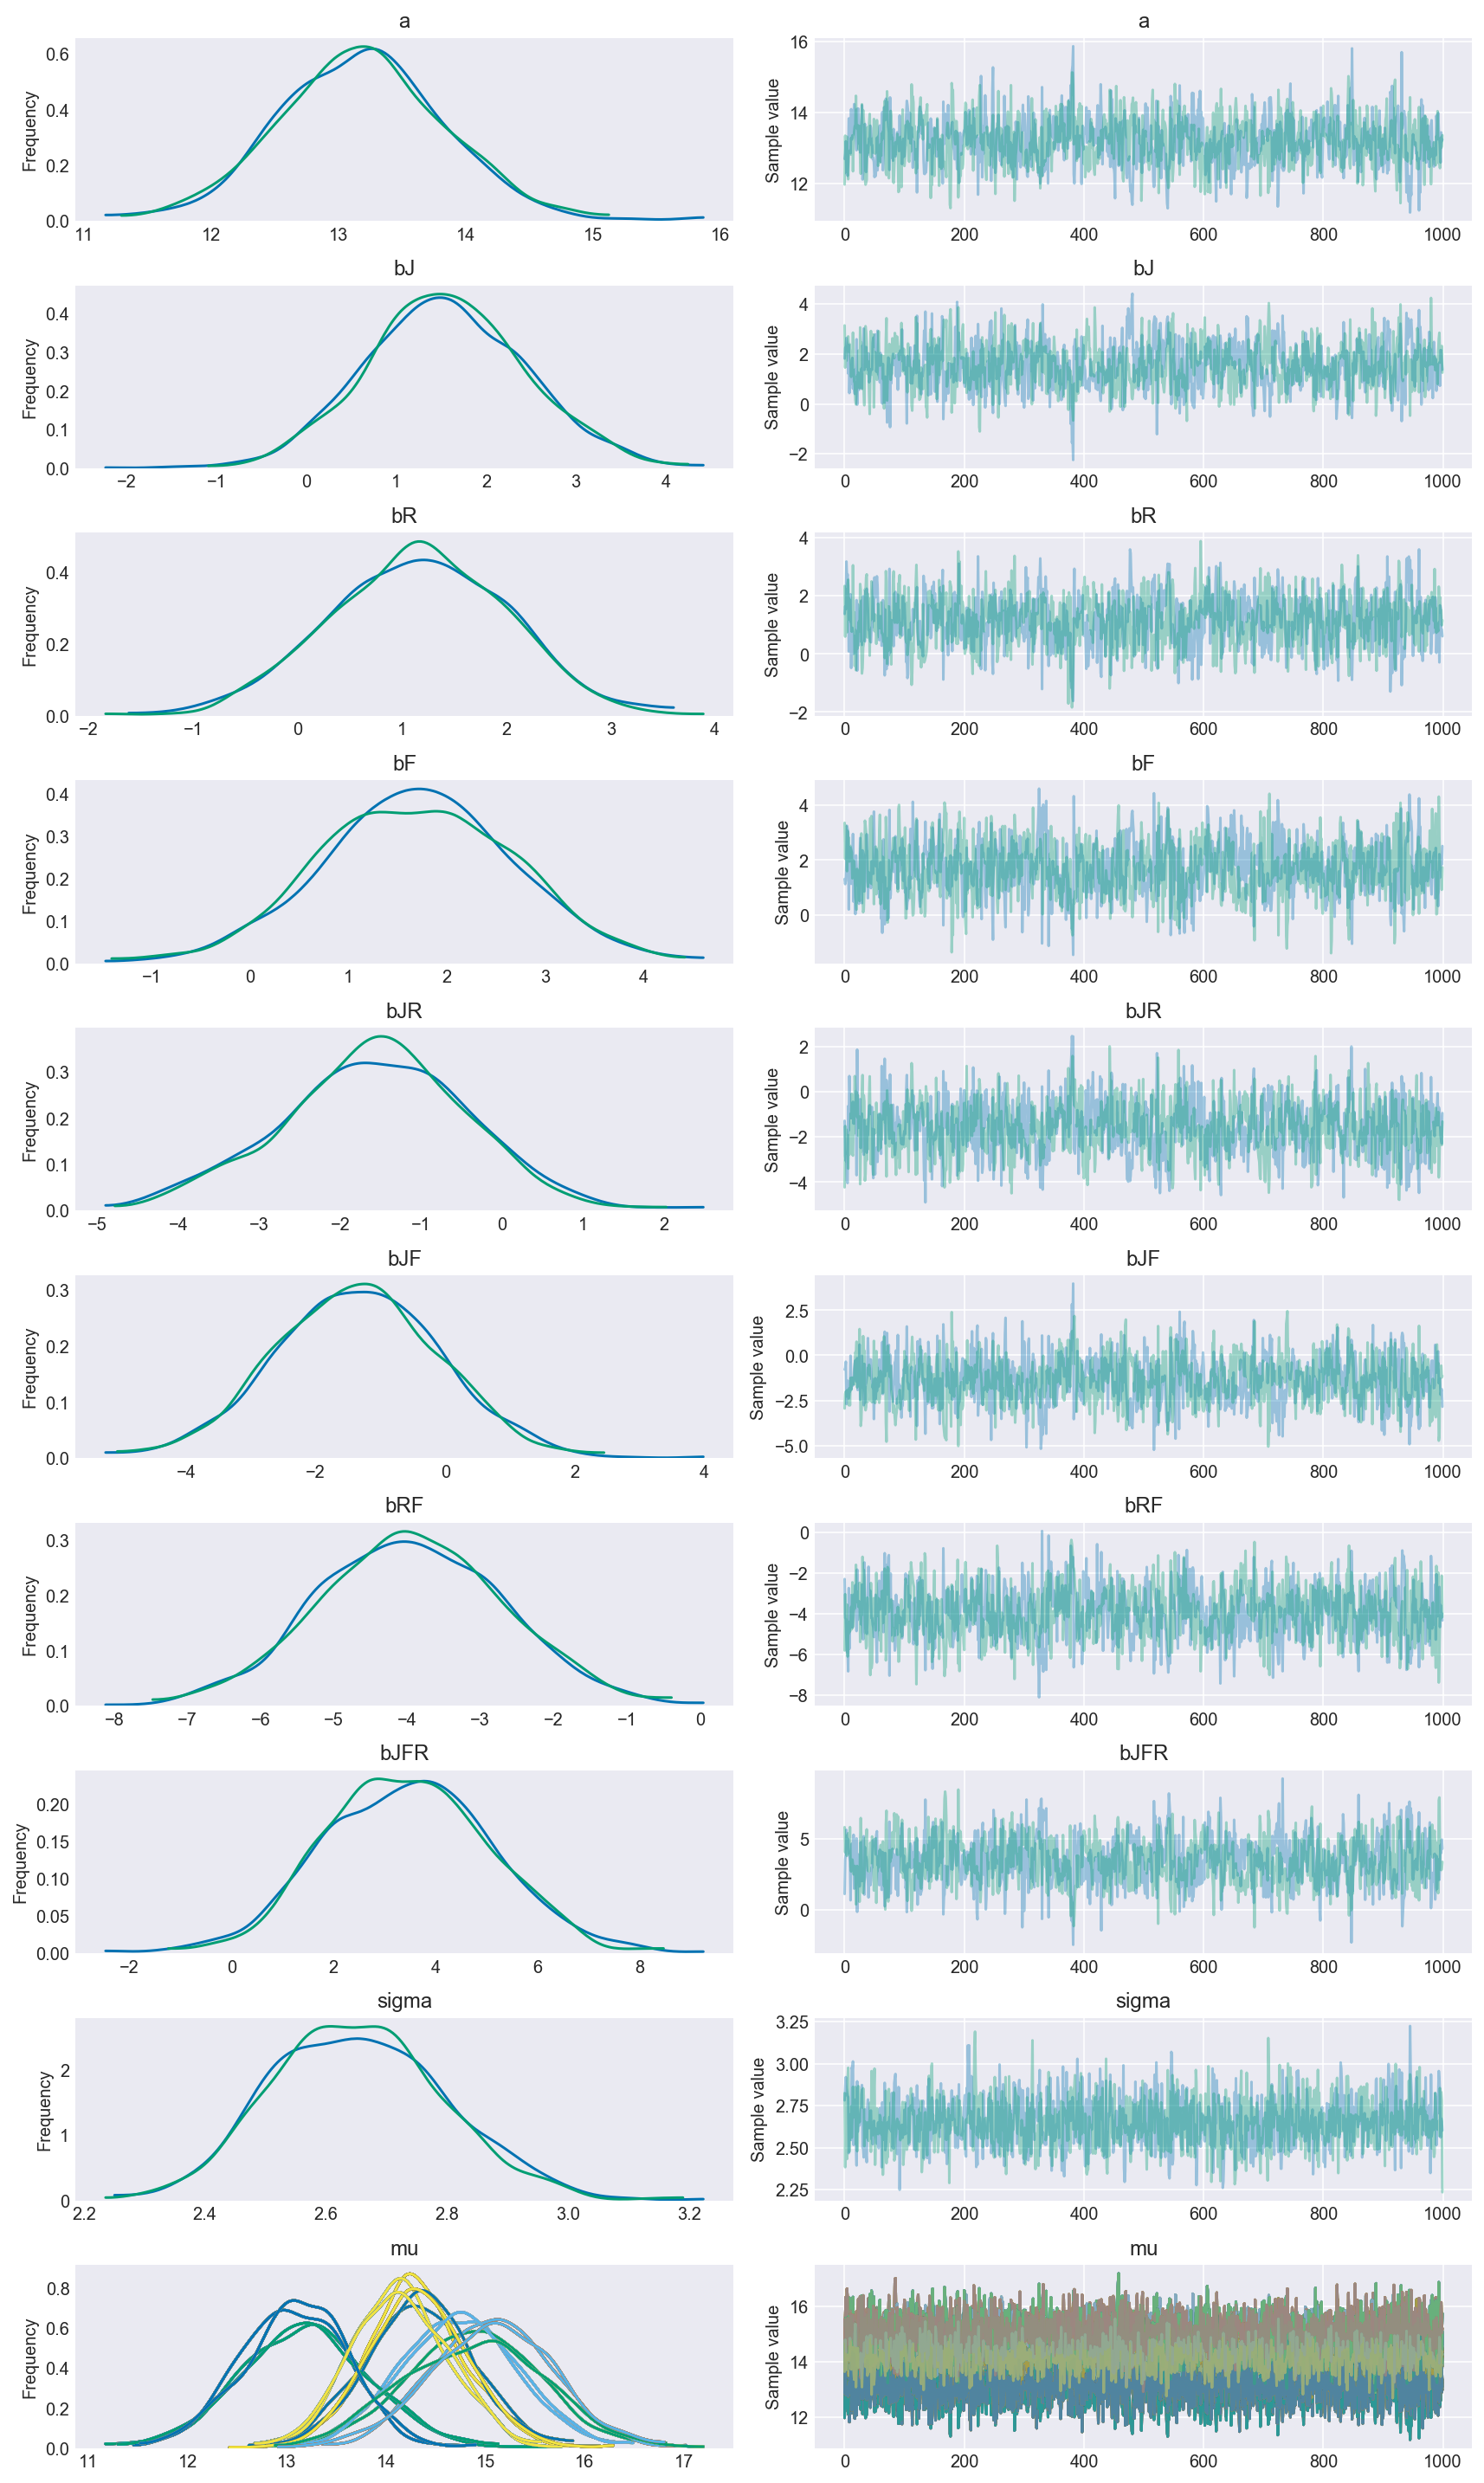

In [16]:
pm.traceplot(trace_hw_7_1);

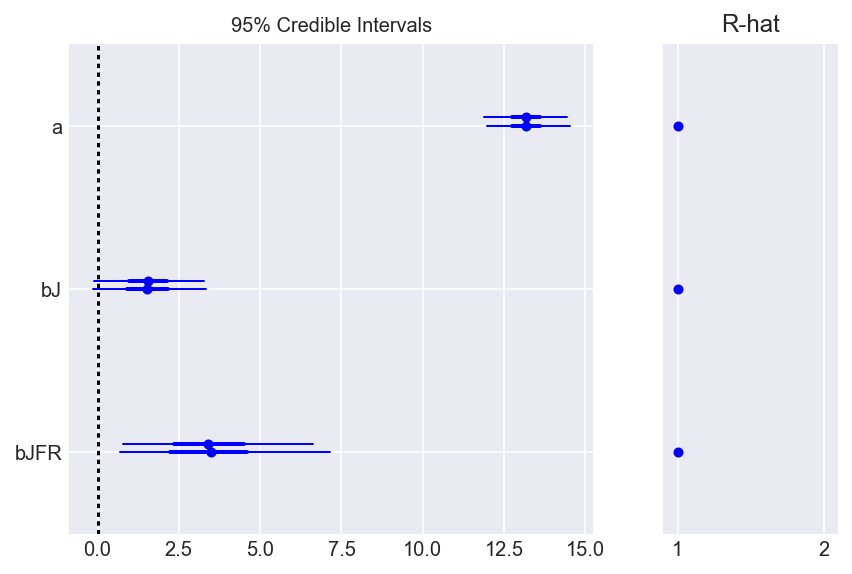

In [17]:
pm.forestplot(trace_hw_7_1, varnames=['a', 'bJ', 'bJFR']);

No 3-way interaction

In [18]:
with pm.Model() as hw_7_2:
    a = pm.Normal('a', mu=0, sd=normal_sd)
    bJ = pm.Normal('bJ', mu=0, sd=normal_sd)
    bR = pm.Normal('bR', mu=0, sd=normal_sd)
    bF = pm.Normal('bF', mu=0, sd=normal_sd)
    bJR = pm.Normal('bJR', mu=0, sd=normal_sd)
    bJF = pm.Normal('bJF', mu=0, sd=normal_sd)
    bRF = pm.Normal('bRF', mu=0, sd=normal_sd)
    bJFR = pm.Normal('bJFR', mu=0, sd=normal_sd)
    sigma = pm.HalfCauchy('sigma', beta=4)
    mu = pm.Deterministic('mu', a + bJ*d['judge.amer'] + bR*d['wine.amer'] + bF*d['flight'] + \
                         bJR*d['judge.amer']*d['wine.amer'] + \
                         bJF*d['judge.amer']*d['flight'] + \
                         bRF*d['wine.amer']*d['flight'])
    score = pm.Normal('score', mu, sigma, observed=d['score_c'])
    trace_hw_7_2 = pm.sample(1000, tune=1000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:10<00:00, 251.58it/s]


Take the last interaction out (bRF) and recompute it. And then just keep taking the other ones out until you are left with only linear effects.

In [19]:
with pm.Model() as hw_7_3:
    a = pm.Normal('a', mu=0, sd=normal_sd)
    bJ = pm.Normal('bJ', mu=0, sd=normal_sd)
    bR = pm.Normal('bR', mu=0, sd=normal_sd)
    bF = pm.Normal('bF', mu=0, sd=normal_sd)
    bJR = pm.Normal('bJR', mu=0, sd=normal_sd)
    bJF = pm.Normal('bJF', mu=0, sd=normal_sd)
    bRF = pm.Normal('bRF', mu=0, sd=normal_sd)
    bJFR = pm.Normal('bJFR', mu=0, sd=normal_sd)
    sigma = pm.HalfCauchy('sigma', beta=4)
    mu = pm.Deterministic('mu', a + bJ*d['judge.amer'] + bR*d['wine.amer'] + bF*d['flight'] + \
                         bJR*d['judge.amer']*d['wine.amer'] + \
                         bJF*d['judge.amer']*d['flight'])
    score = pm.Normal('score', mu, sigma, observed=d['score_c'])
    trace_hw_7_3 = pm.sample(1000, tune=1000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:08<00:00, 222.82it/s]


In [20]:
with pm.Model() as hw_7_4:
    a = pm.Normal('a', mu=0, sd=normal_sd)
    bJ = pm.Normal('bJ', mu=0, sd=normal_sd)
    bR = pm.Normal('bR', mu=0, sd=normal_sd)
    bF = pm.Normal('bF', mu=0, sd=normal_sd)
    bJR = pm.Normal('bJR', mu=0, sd=normal_sd)
    bJF = pm.Normal('bJF', mu=0, sd=normal_sd)
    bRF = pm.Normal('bRF', mu=0, sd=normal_sd)
    bJFR = pm.Normal('bJFR', mu=0, sd=normal_sd)
    sigma = pm.HalfCauchy('sigma', beta=4)
    mu = pm.Deterministic('mu', a + bJ*d['judge.amer'] + bR*d['wine.amer'] + bF*d['flight'] + \
                         bJR*d['judge.amer']*d['wine.amer'])
    score = pm.Normal('score', mu, sigma, observed=d['score_c'])
    trace_hw_7_4 = pm.sample(1000, tune=1000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:07<00:00, 257.62it/s]


In [21]:
with pm.Model() as hw_7_5:
    a = pm.Normal('a', mu=0, sd=normal_sd)
    bJ = pm.Normal('bJ', mu=0, sd=normal_sd)
    bR = pm.Normal('bR', mu=0, sd=normal_sd)
    bF = pm.Normal('bF', mu=0, sd=normal_sd)
    bJR = pm.Normal('bJR', mu=0, sd=normal_sd)
    bJF = pm.Normal('bJF', mu=0, sd=normal_sd)
    bRF = pm.Normal('bRF', mu=0, sd=normal_sd)
    bJFR = pm.Normal('bJFR', mu=0, sd=normal_sd)
    sigma = pm.HalfCauchy('sigma', beta=4)
    mu = pm.Deterministic('mu', a + bJ*d['judge.amer'] + bR*d['wine.amer'] + bF*d['flight'])
    score = pm.Normal('score', mu, sigma, observed=d['score_c'])
    trace_hw_7_5 = pm.sample(1000, tune=1000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:06<00:00, 315.77it/s]


Compare models using WAIC.

In [22]:
comp_models = pm.compare([trace_hw_7_1, trace_hw_7_2, trace_hw_7_3, trace_hw_7_4, trace_hw_7_5],
                         [hw_7_1, hw_7_2, hw_7_3, hw_7_4, hw_7_5])
comp_models.loc[:,'model'] = pd.Series(['hw7.1', 'hw7.2', 'hw7.3', 'hw7.4', 'hw7.5'])
comp_models = comp_models.set_index('model')
comp_models

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
model,,,,,,,
hw7.5,867.76,4.59,0,0.67,17.14,0,0
hw7.4,869.72,5.5,1.95,0,17.02,0.77,0
hw7.1,869.86,8.47,2.1,0.33,17.76,4.91,0
hw7.2,870.05,7.48,2.29,0,17.19,3.99,0
hw7.3,871.41,6.37,3.64,0,17.11,0.9,0


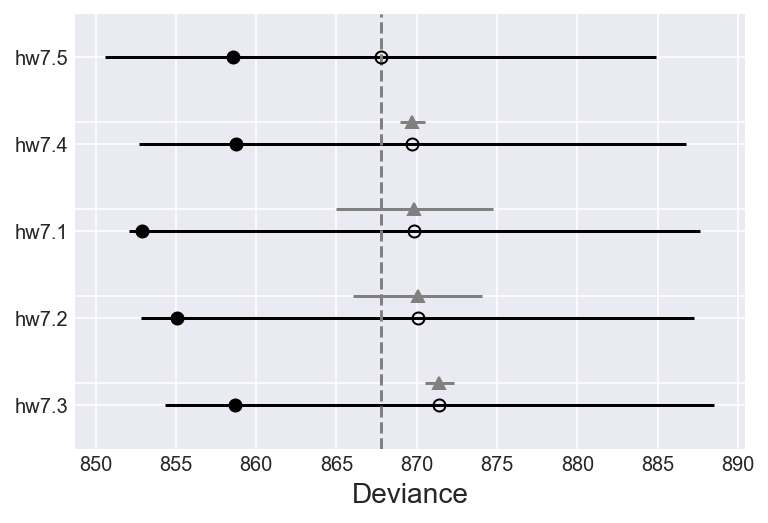

In [25]:
pm.compareplot(comp_models);

Let's try plotting a triptych for three values. Since there is no link function implemented in pymc3 I have to use a loop.

First the *full interaction*.

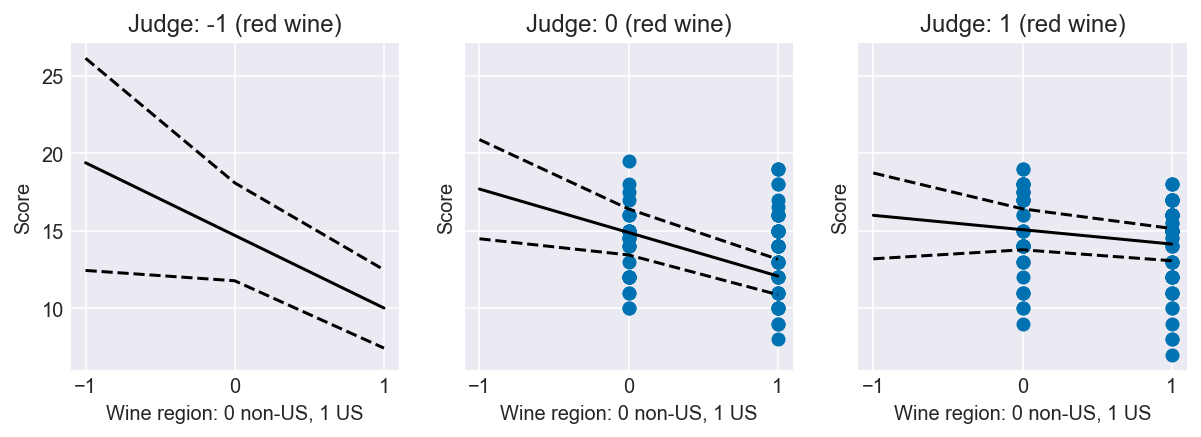

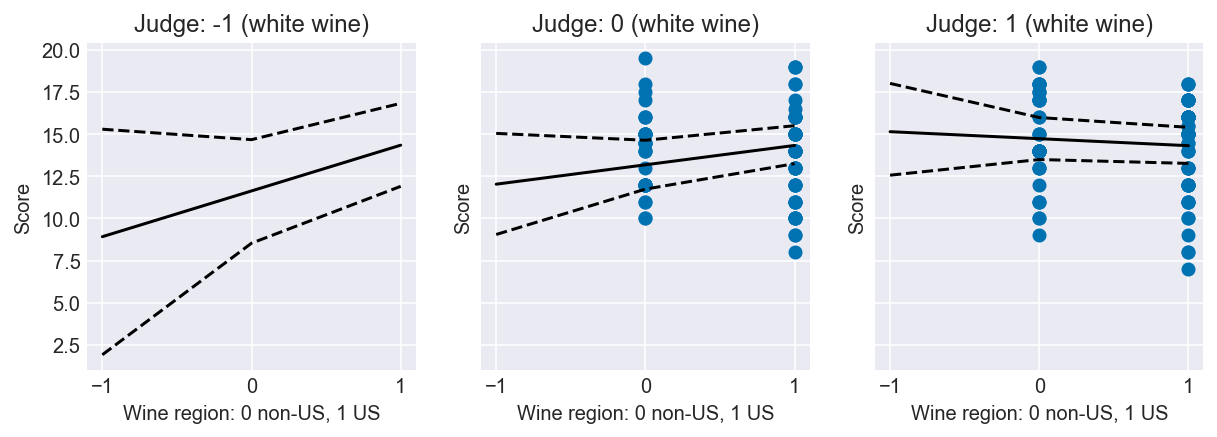

In [23]:
f, axs = plt.subplots(1, 3, sharey=True, figsize=(10,3))
# Loop over values of judge (american or not) vs wine region while keeping the flight constant
wine = 1  # 1: red, 0: white
region_seq = range(-1, 2, 1)  # Values of region that we change over.
mu_judge = np.zeros((len(region_seq), len(trace_hw_7_1['a'])))
for ax, judge in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d['judge.amer'] == judge] # extract data based on judge
    ax.plot(dt['wine.amer'], dt['score_c'], 'C0o')  # plot the data points
    
    for x, i_seq in enumerate(region_seq):  # keep the wine red
        mu_judge[x] = trace_hw_7_1['a'] + trace_hw_7_1['bJ']*judge + trace_hw_7_1['bR']*i_seq + \
                      trace_hw_7_1['bF']*wine + trace_hw_7_1['bJR']*judge*i_seq + \
                      trace_hw_7_1['bJF']*judge*wine + trace_hw_7_1['bRF']*i_seq*wine + \
                      trace_hw_7_1['bJFR']*judge*wine*i_seq
    mu_mean_judge = mu_judge.mean(1)
    mu_hpd_judge = pm.hpd(mu_judge.T, alpha=0.03)  # 97% probability interval: 1-.97 = .03
    ax.plot(region_seq, mu_mean_judge, 'k')
    ax.plot(region_seq, mu_hpd_judge.T[0], 'k--')
    ax.plot(region_seq, mu_hpd_judge.T[1], 'k--')
    ax.set_ylabel('Score')
    ax.set_xlabel('Wine region: 0 non-US, 1 US')
    ax.set_title('Judge: {:d} (red wine)'.format(judge))
    ax.set_xticks(region_seq)

f, axs = plt.subplots(1, 3, sharey=True, figsize=(10,3))    
wine = 0  # 1: red, 0: white
for ax, judge in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d['judge.amer'] == judge] # extract data based on judge
    ax.plot(dt['wine.amer'], dt['score_c'], 'C0o')  # plot the data points
    
    for x, i_seq in enumerate(region_seq):  # keep the wine red
        mu_judge[x] = trace_hw_7_1['a'] + trace_hw_7_1['bJ']*judge + trace_hw_7_1['bR']*i_seq + \
                      trace_hw_7_1['bF']*wine + trace_hw_7_1['bJR']*judge*i_seq + \
                      trace_hw_7_1['bJF']*judge*wine + trace_hw_7_1['bRF']*i_seq*wine + \
                      trace_hw_7_1['bJFR']*judge*wine*i_seq
    mu_mean_judge = mu_judge.mean(1)
    mu_hpd_judge = pm.hpd(mu_judge.T, alpha=0.03)  # 97% probability interval: 1-.97 = .03
    ax.plot(region_seq, mu_mean_judge, 'k')
    ax.plot(region_seq, mu_hpd_judge.T[0], 'k--')
    ax.plot(region_seq, mu_hpd_judge.T[1], 'k--')
    ax.set_ylabel('Score')
    ax.set_xlabel('Wine region: 0 non-US, 1 US')
    ax.set_title('Judge: {:d} (white wine)'.format(judge))
    ax.set_xticks(region_seq)

The graphs show that when looking at red wines as the judges change from non-US to US the score increases for US-wines. The -1 judges refer to fictional judges that are far removed from the US judges in terms of scoring to underline the interactive effect. The -1 wine region is an otherworldy fictional region that apparently scores the highest. As judges move towards those from the USA the scores for red American wines increase. The effect is the opposite for white American wines.

Now the simple linear model. This one came out first and is very close to the full interaction model.

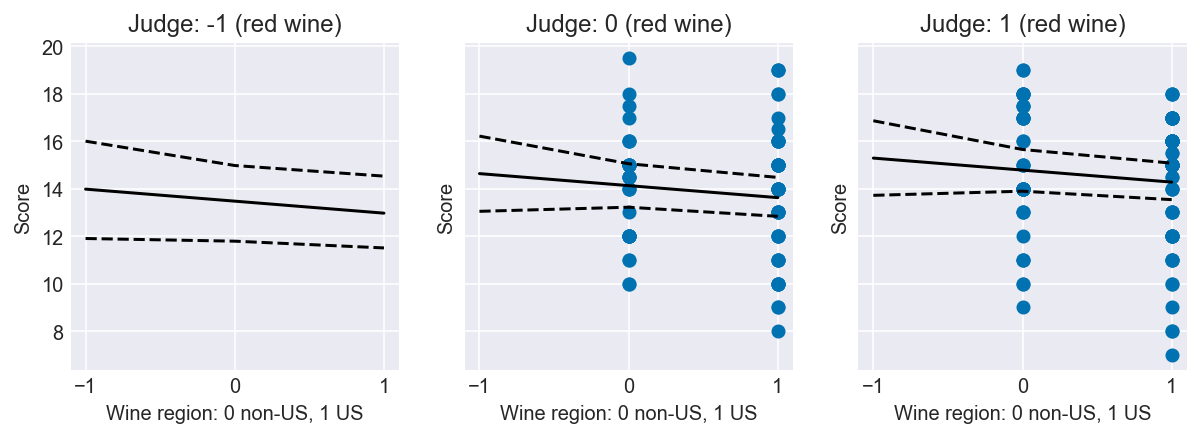

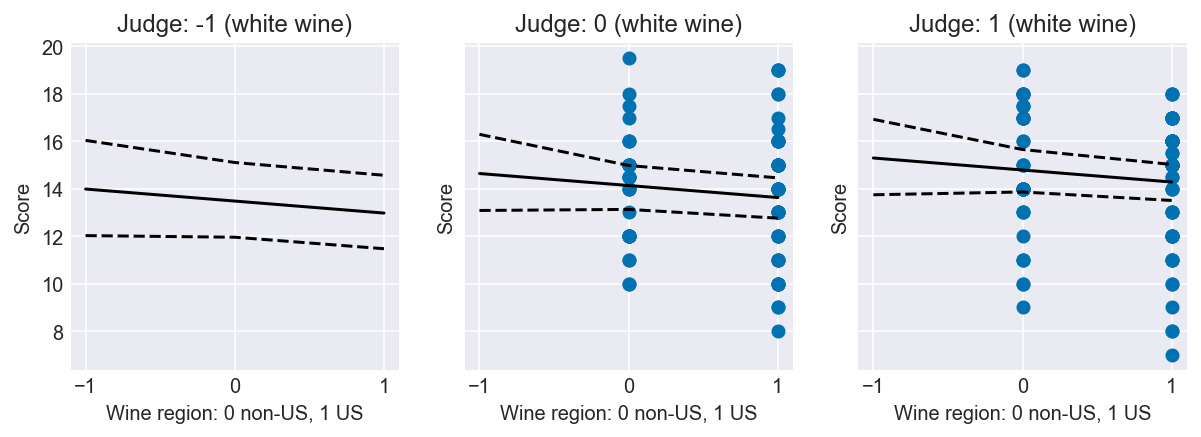

In [24]:
f, axs = plt.subplots(1, 3, sharey=True, figsize=(10,3))
# Loop over values of judge (american or not) vs wine region while keeping the flight constant
wine = 1  # 1: red, 0: white
region_seq = range(-1, 2, 1)  # Values of region that we change over.
mu_judge = np.zeros((len(region_seq), len(trace_hw_7_5['a'])))
for ax, judge in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d['judge.amer'] == judge] # extract data based on judge
    ax.plot(dt['wine.amer'], dt['score_c'], 'C0o')  # plot the data points
    
    for x, i_seq in enumerate(region_seq):  # keep the wine red
        mu_judge[x] = trace_hw_7_5['a'] + trace_hw_7_5['bJ']*judge + trace_hw_7_5['bR']*i_seq + \
                      trace_hw_7_5['bF']*wine
    mu_mean_judge = mu_judge.mean(1)
    mu_hpd_judge = pm.hpd(mu_judge.T, alpha=0.03)  # 97% probability interval: 1-.97 = .03
    ax.plot(region_seq, mu_mean_judge, 'k')
    ax.plot(region_seq, mu_hpd_judge.T[0], 'k--')
    ax.plot(region_seq, mu_hpd_judge.T[1], 'k--')
    ax.set_ylabel('Score')
    ax.set_xlabel('Wine region: 0 non-US, 1 US')
    ax.set_title('Judge: {:d} (red wine)'.format(judge))
    ax.set_xticks(region_seq)

f, axs = plt.subplots(1, 3, sharey=True, figsize=(10,3))    
mu_judge = np.zeros((len(region_seq), len(trace_hw_7_5['a'])))
wine = 0  # 1: red, 0: white
for ax, judge in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d['judge.amer'] == judge] # extract data based on judge
    ax.plot(dt['wine.amer'], dt['score_c'], 'C0o')  # plot the data points
    
    for x, i_seq in enumerate(region_seq):  # keep the wine red
        mu_judge[x] = trace_hw_7_5['a'] + trace_hw_7_5['bJ']*judge + trace_hw_7_5['bR']*i_seq + \
                      trace_hw_7_5['bF']*wine
    mu_mean_judge = mu_judge.mean(1)
    mu_hpd_judge = pm.hpd(mu_judge.T, alpha=0.03)  # 97% probability interval: 1-.97 = .03
    ax.plot(region_seq, mu_mean_judge, 'k')
    ax.plot(region_seq, mu_hpd_judge.T[0], 'k--')
    ax.plot(region_seq, mu_hpd_judge.T[1], 'k--')
    ax.set_ylabel('Score')
    ax.set_xlabel('Wine region: 0 non-US, 1 US')
    ax.set_title('Judge: {:d} (white wine)'.format(judge))
    ax.set_xticks(region_seq)

For both red and white wines the slope is similar and negative meaning that US judges rate wines from the US with a lower score. The full interaction predicts the score much better than the simple model.